In [1]:
import sklearn
import io
import pickle
import numpy as np
import pandas as pd
import os
import random
import skimage
from skimage import io, exposure
from skimage.io import imread, imshow
from skimage.filters import gaussian
from skimage.transform import rescale
import matplotlib.pyplot as plt

In [2]:
IMAGE_COUNT = 5 #number of images to randomly select from folder
PIECE_LIST = 'prnbqkPRNBQK' #FEN piece codes. Case represents color.
CLASSIFIER_NAME = 'clf_acc09994_tm20201118.pkl'
IMAGE_PATH = './archive/train/'#path to image folder
PIECE_NUM_DICT = {}
for ii in range(1, len(PIECE_LIST)+1):
    PIECE_NUM_DICT[ii] = PIECE_LIST[ii-1]

In [3]:
with open(CLASSIFIER_NAME, 'rb') as f:
    clf = pickle.load(f)

In [4]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False


def mat_to_fen(board_arr):
    fen = []
    fen_dashed = ""
    
    for row in range(8):
        row_str = ""
        blank_count = 0
        for col in range(8):
            idx = row*8 + col
            piece = board_arr[idx]
            if piece > 0:
                if blank_count > 0:
                    row_str = row_str+str(blank_count)
                    blank_count = 0
                row_str = row_str + str(PIECE_NUM_DICT[piece])
            else:
                blank_count = blank_count+1
        if blank_count > 0:
            row_str = row_str+str(blank_count)
            blank_count=0
        fen.append(row_str)
        
    for row in fen:
        if fen_dashed == "":
            fen_dashed = row
        else:
            fen_dashed = fen_dashed+ "-" + row
    
    return fen_dashed


In [5]:
def load_imgs(count, path):
    
   
    #if filecount in folder is less than the number we ask to retrieve, get all files in folder
    if len(list(os.listdir(path))) < count:
        count = len(list(os.listdir(path)))
        
    print(os.listdir(path))    
    board_names = []
    board_imgs = []
    
    for counter in range(count):
        img_name = random.choice(list(os.listdir(path)))
        img = imread(path + img_name , as_gray = True)
        img = preprocess(img)
        board_names.append(img_name)
        board_imgs.append(img)
    
    return board_names, board_imgs


def preprocess(img):
    img = skimage.filters.gaussian(img, sigma = 3)
    img = rescale(img, .2, anti_aliasing = True)
    return img


def check_imgs(imgs, names):
    
    readout = []

    for index, board in enumerate(imgs):

        board_arr = np.zeros(64)
        tiles = skimage.util.shape.view_as_blocks(board, block_shape=(10, 10))


        for row in range(8):
            for col in range(8):
                idx = row*8 + col
                board_arr[idx] = clf.predict(np.ndarray.flatten(tiles[row][col]).reshape(1,-1))

        fen = mat_to_fen(board_arr)
        readout.append([names[index], fen, imgs[index]])
    return readout

def print_readout(readout):

    plt.figure()
    f, axarr = plt.subplots(len(readout),1, figsize=(70,70)) 
    for index,board in enumerate(readout):
        axarr[index].set_title('File Name / Predicted Fen:\n' +board[0]+"\n"+board[1],loc='left')
        org_img = imread(IMAGE_PATH + board[0])
        axarr[index].imshow(org_img)
        

5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<Figure size 432x288 with 0 Axes>

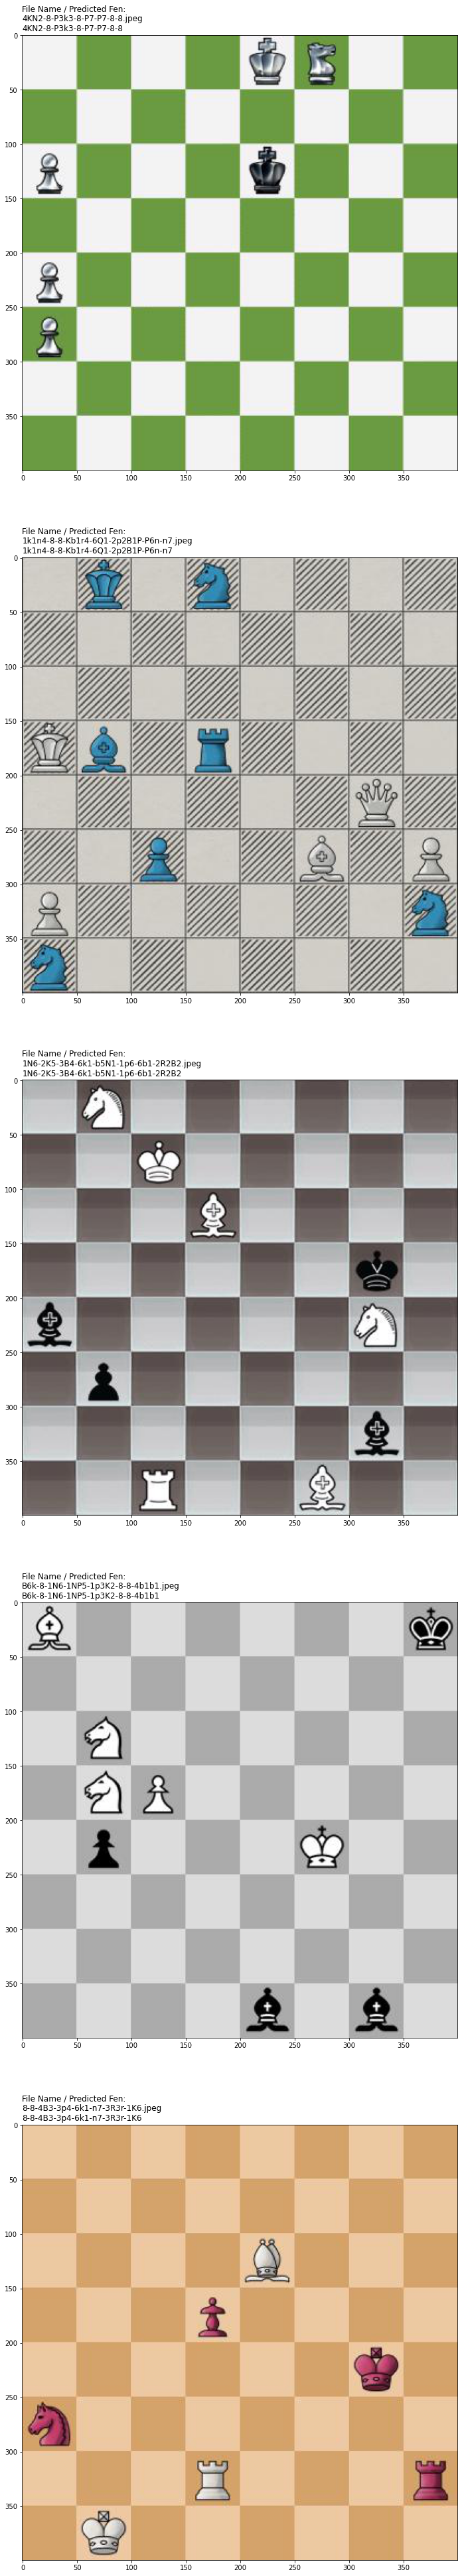

In [6]:
names, imgs  = load_imgs(IMAGE_COUNT, IMAGE_PATH)
readout = check_imgs(imgs, names)
print_readout(readout)
